# Lab 4

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy import optimize
from scipy import stats
from scipy.stats.distributions import gamma, expon, norm, chi2
import seaborn as sns
from IPython.display import display, Math
from functools import partial

In [2]:
path_to_file = '/opt/notebooks/owid-covid-data.csv'
source_df = pd.read_csv(path_to_file)

# df = source_df[[
#     'hospital_beds_per_thousand', 'people_vaccinated', 'total_tests', # predictors
#     'new_cases', 'excess_mortality_cumulative_per_million' # targets
# ]].copy().dropna()

df = source_df[[
    'date',
    
    'hospital_beds_per_thousand', 'people_vaccinated', 'total_tests', # predictors
    'new_cases', 'excess_mortality_cumulative_per_million' # targets
]].copy().dropna()

In [3]:
pd.set_option('display.max_columns', None)
source_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.122,0.122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231404,ZWE,Africa,Zimbabwe,2022-10-26,257893.0,0.0,0.0,5606.0,0.0,0.0,15801.745,0.000,0.0,343.494,0.0,0.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231405,ZWE,Africa,Zimbabwe,2022-10-27,257893.0,0.0,0.0,5606.0,0.0,0.0,15801.745,0.000,0.0,343.494,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231406,ZWE,Africa,Zimba

## 2

In [5]:
from datetime import datetime

# already daily
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [6]:
hospital_beds_per_thousand_daily = df.groupby('date', as_index=False).agg({'hospital_beds_per_thousand': 'sum'})
hospital_beds_per_thousand_daily = hospital_beds_per_thousand_daily.sort_values('date')

In [7]:
people_vaccinated_daily = df.groupby('date', as_index=False).agg({'people_vaccinated': 'sum'})
people_vaccinated_daily = people_vaccinated_daily.sort_values('date')

In [8]:
total_tests_daily = df.groupby('date', as_index=False).agg({'total_tests': 'sum'})
total_tests_daily = total_tests_daily.sort_values('date')

In [9]:
new_cases_daily = df.groupby('date', as_index=False).agg({'new_cases': 'sum'})
new_cases_daily = new_cases_daily.sort_values('date')

In [10]:
emcpm_daily = df.groupby('date', as_index=False).agg({'excess_mortality_cumulative_per_million': 'sum'})
emcpm_daily = emcpm_daily.sort_values('date')

In [11]:
merged = pd.merge(
    hospital_beds_per_thousand_daily,
    people_vaccinated_daily
)

merged = pd.merge(
    merged,
    total_tests_daily
)

merged = pd.merge(
    merged,
    new_cases_daily
)

merged = pd.merge(
    merged,
    emcpm_daily
)

merged

,date,hospital_beds_per_thousand,people_vaccinated,total_tests,new_cases,excess_mortality_cumulative_per_million
0,2020-12-13,2.770,32129.0,2.272770e+08,190625.0,1178.313352
1,2020-12-20,19.930,1221321.0,2.764065e+08,197903.0,1844.320544
2,2020-12-27,70.330,3528262.0,4.051998e+08,194182.0,13436.606172
3,2020-12-31,7.960,45809.0,7.501389e+06,13208.0,853.126320
4,2021-01-03,91.520,8026842.0,4.355922e+08,270335.0,15289.668294
...,...,...,...,...,...,...
90,2022-05-29,109.389,593522418.0,2.323146e+09,84307.0,60767.269244
91,2022-05-31,20.010,192257954.0,1.472748e+08,27210.0,3188.788449
92,2022-06-05,122.069,606519956.0,2.367713e+09,101789.0,66985.248061
93,2022-06-12,102.625,575811202.0,2.283280e+09,65042.0,52413.656082


In [12]:
# predictors
predictors = ['hospital_beds_per_thousand', 'people_vaccinated', 'total_tests']
# beds = df['hospital_beds_per_thousand'].dropna()
# vac = df['people_vaccinated'].dropna()
# tests = df['total_tests'].dropna()

# targets
targets = ['new_cases', 'excess_mortality_cumulative_per_million']
# cases = df['new_cases'].dropna()
# emcpm = df['excess_mortality_cumulative_per_million'].dropna()

all_vars = predictors + targets

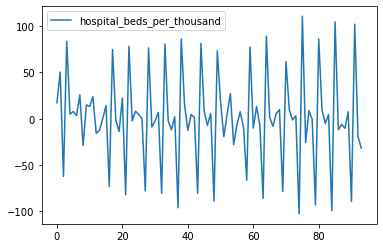

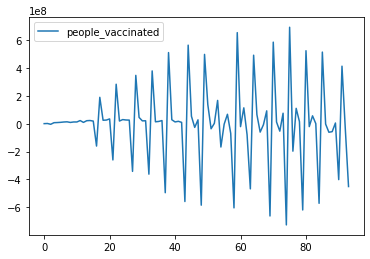

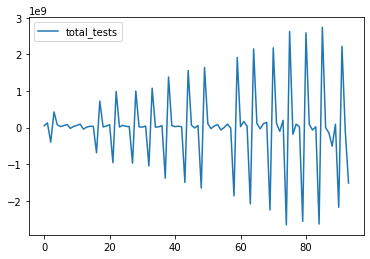

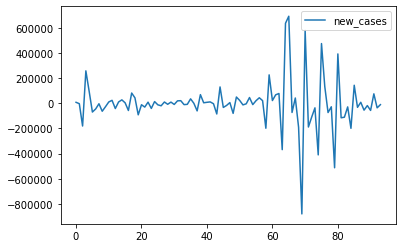

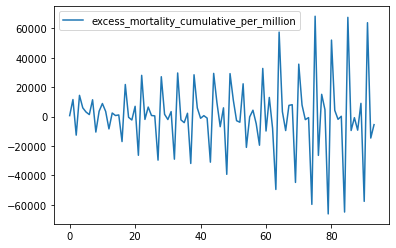

In [13]:
# trend subtraction using differences
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
        
    return pd.Series(diff)

diff_df = pd.DataFrame()

for var in all_vars:
    diff_df[var] = difference(merged[var], interval=1)
    diff_df.plot(y=var)

diff_df.fillna(value=0, inplace=True)

# diff = difference(dataset=merged['hospital_beds_per_thousand'], interval=1)

# plt.plot(diff)
# plt.show()

In [15]:
# find the trend
def trendline(data, order=9):
    # polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

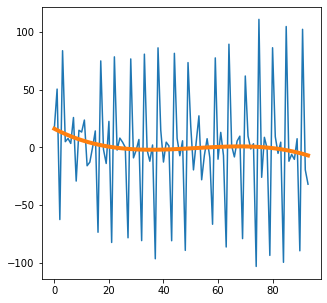

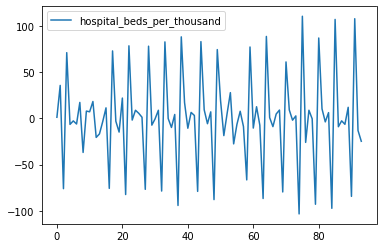

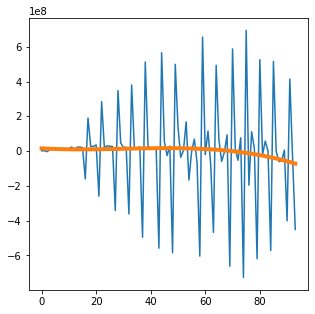

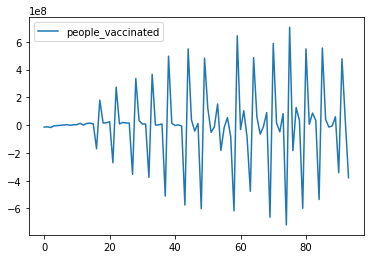

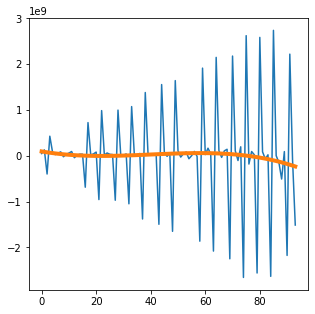

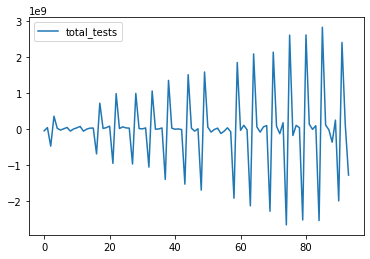

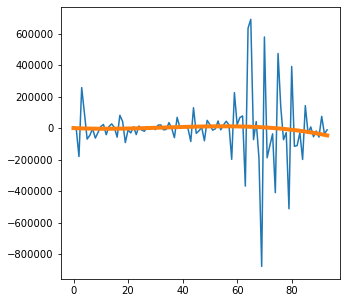

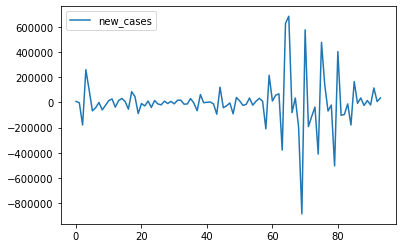

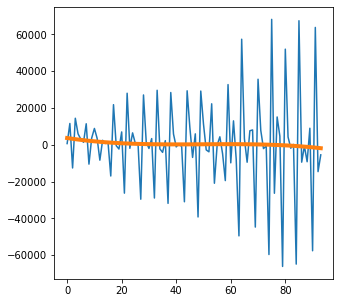

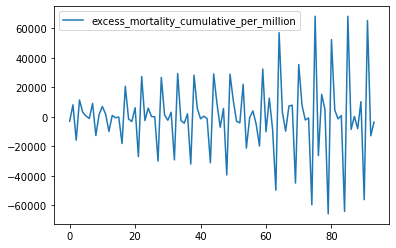

In [38]:
trendless_data = pd.DataFrame()

for var in all_vars:
    trend = trendline(diff_df[var], 3)
    plt.figure(figsize=(5, 5))
    plt.plot(diff_df[var])
    plt.plot(trend, linewidth=4)
    plt.show()
    trendless_data[var] = diff_df[var] - trend
    trendless_data.plot(y=var)

## 3

In [39]:
def pearson_data(x, y, a=0.05):
    r, p = scipy.stats.pearsonr(x, y)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size-3)
    z = scipy.stats.norm.ppf(1-a/2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))

    return r, p, lo, hi

def print_pearson(data, var_x, var_y):
    x = data[var_x]
    y = data[var_y]
    r, p, lo, hi = pearson_data(x, y)
    print(var_x + " and " + var_y + ": pearson: %s,\
    significance level: %s, \
    confidence interval: [%s .. %s]" % (r, p, lo, hi))

In [40]:
print_pearson(df, targets[0], targets[1])
for target in targets:
    for predictor in predictors:
        print('---------------')
        print('Raw data:')
        print_pearson(df, target, predictor)
        print('Differences:')
        print_pearson(diff_df, target, predictor)
        print('Without polynomial trend:')
        print_pearson(trendless_data, target, predictor)

new_cases and excess_mortality_cumulative_per_million: pearson: 0.001958959233908022,    significance level: 0.9212381660428427,     confidence interval: [-0.036860252752326725 .. 0.04077226806165009]
---------------
Raw data:
new_cases and hospital_beds_per_thousand: pearson: 0.06655606172932449,    significance level: 0.0007710100289589149,     confidence interval: [0.02781150269639487 .. 0.10510094601104387]
Differences:
new_cases and hospital_beds_per_thousand: pearson: 0.5957653398946757,    significance level: 2.384933588380831e-10,     confidence interval: [0.4471213630066729 .. 0.7123883629833867]
Without polynomial trend:
new_cases and hospital_beds_per_thousand: pearson: 0.5980722525071166,    significance level: 1.9517028364068455e-10,     confidence interval: [0.44998418443202365 .. 0.7141489447262791]
---------------
Raw data:
new_cases and people_vaccinated: pearson: 0.4005544745619088,    significance level: 6.832869276082844e-99,     confidence interval: [0.367451228862

<AxesSubplot:>

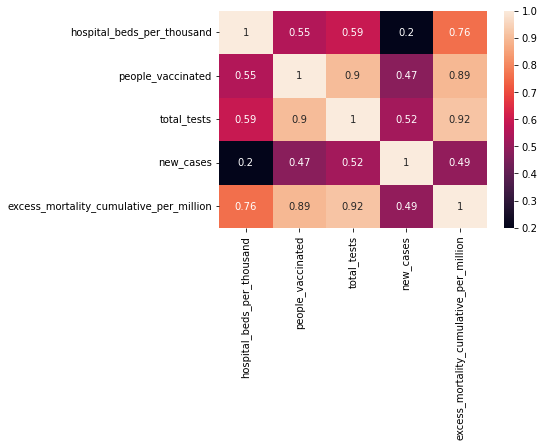

In [41]:
import seaborn as sns
sns.heatmap(merged.corr(method='pearson'), annot=True)

<AxesSubplot:>

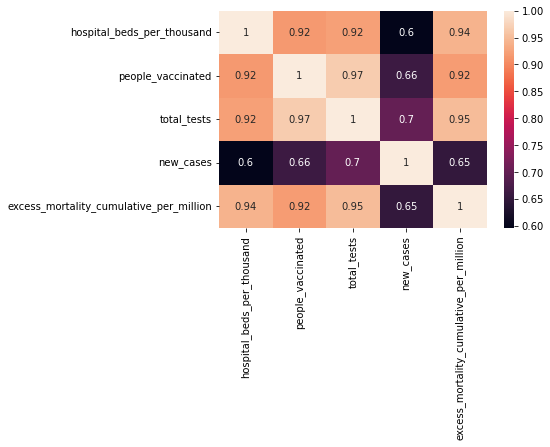

In [42]:
sns.heatmap(diff_df.corr(method='pearson'), annot=True)

<AxesSubplot:>

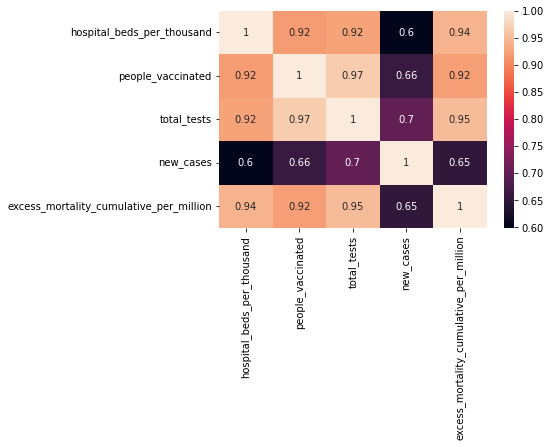

In [46]:
sns.heatmap(trendless_data.corr(method='pearson'), annot=True)

## 4